In [114]:
! pip install -q gdown

import sqlite3
import os
import pandas as pd
import gdown
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import xml.etree.ElementTree as ET
import math
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

warnings.filterwarnings('ignore')

In [2]:
db_name = 'database.sqlite'
db_folder = 'src'
if not os.path.exists(db_folder):
    os.mkdir(db_folder)

db_path = os.path.join(db_folder, db_name)

if not os.path.exists(db_path):
    url_db = f'https://drive.google.com/uc?id=1Ez76povTEsoi9ZJj0I8swdczV4F3GQiF'
    gdown.download(url_db, db_path)

con = sqlite3.connect(db_path)


def req(query, connect=con):
    return pd.read_sql_query(query, connect)

In [3]:
req('''SELECT name FROM sqlite_schema WHERE type='table' AND name NOT LIKE 'sqlite_%';''')

,name
0,Player_Attributes
1,Player
2,Match
3,League
4,Country
5,Team
6,Team_Attributes


In [4]:
players = req('''
SELECT Player.player_api_id,
       player_name,
       birthday,
       date,
       overall_rating,
       potential,
       preferred_foot,
       attacking_work_rate,
       defensive_work_rate,
       crossing,
       finishing,
       heading_accuracy,
       short_passing,
       volleys,
       dribbling,
       curve,
       free_kick_accuracy,
       long_passing,
       ball_control,
       acceleration,
       sprint_speed,
       agility,
       reactions,
       balance,
       shot_power,
       jumping,
       stamina,
       strength,
       long_shots,
       aggression,
       interceptions,
       positioning,
       vision,
       penalties,
       marking,
       standing_tackle,
       sliding_tackle,
       gk_diving,
       gk_handling,
       gk_kicking,
       gk_positioning,
       gk_reflexes
FROM Player_Attributes
         LEFT JOIN Player ON Player_Attributes.player_api_id = Player.player_api_id;
''')
players.to_csv('./src/players.csv', index=False)
players.head(5)

,player_api_id,player_name,birthday,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,1992-02-29 00:00:00,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,Aaron Appindangoye,1992-02-29 00:00:00,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,Aaron Appindangoye,1992-02-29 00:00:00,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,505942,Aaron Appindangoye,1992-02-29 00:00:00,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,505942,Aaron Appindangoye,1992-02-29 00:00:00,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [5]:
teams = req('''
SELECT Team.team_api_id,
       team_long_name,
       team_short_name,
       defenceTeamWidthClass,
       defenceTeamWidth,
       defencePressureClass,
       defencePressure,
       defenceDefenderLineClass,
       defenceAggressionClass,
       defenceAggression,
       date,
       chanceCreationShootingClass,
       chanceCreationShooting,
       chanceCreationPositioningClass,
       chanceCreationPassingClass,
       chanceCreationPassing,
       chanceCreationCrossingClass,
       chanceCreationCrossing,
       buildUpPlaySpeedClass,
       buildUpPlaySpeed,
       buildUpPlayPositioningClass,
       buildUpPlayPassingClass,
       buildUpPlayPassing,
       buildUpPlayDribblingClass,
       buildUpPlayDribbling
FROM Team_Attributes
         LEFT JOIN Team ON Team_Attributes.team_api_id = Team.team_api_id;
''')
teams.to_csv('./src/teams.csv', index=False)
teams.head(5)

,team_api_id,team_long_name,team_short_name,defenceTeamWidthClass,defenceTeamWidth,defencePressureClass,defencePressure,defenceDefenderLineClass,defenceAggressionClass,defenceAggression,...,chanceCreationPassing,chanceCreationCrossingClass,chanceCreationCrossing,buildUpPlaySpeedClass,buildUpPlaySpeed,buildUpPlayPositioningClass,buildUpPlayPassingClass,buildUpPlayPassing,buildUpPlayDribblingClass,buildUpPlayDribbling
0,9930,FC Aarau,AAR,Normal,45,Medium,50,Cover,Press,55,...,60,Normal,65,Balanced,60,Organised,Mixed,50,Little,NaN
1,9930,FC Aarau,AAR,Normal,54,Medium,47,Cover,Press,44,...,54,Normal,63,Balanced,52,Organised,Mixed,56,Normal,48.0
2,9930,FC Aarau,AAR,Normal,54,Medium,47,Cover,Press,44,...,54,Normal,63,Balanced,47,Organised,Mixed,54,Normal,41.0
3,8485,Aberdeen,ABE,Wide,70,Medium,60,Cover,Double,70,...,70,Lots,70,Fast,70,Organised,Long,70,Little,NaN
4,8485,Aberdeen,ABE,Normal,52,Medium,47,Cover,Press,47,...,53,Normal,48,Balanced,47,Organised,Mixed,52,Little,NaN


In [6]:
matches = req('''
SELECT Match.id,
       Country.name AS country_name,
       League.name  AS league_name,
       season,
       stage,
       date,
       card,
       match_api_id,
       home_team_api_id,
       away_team_api_id,
       home_team_goal,
       away_team_goal,
       home_player_1,
       home_player_2,
       home_player_3,
       home_player_4,
       home_player_5,
       home_player_6,
       home_player_7,
       home_player_8,
       home_player_9,
       home_player_10,
       home_player_11,
       away_player_1,
       away_player_2,
       away_player_3,
       away_player_4,
       away_player_5,
       away_player_6,
       away_player_7,
       away_player_8,
       away_player_9,
       away_player_10,
       away_player_11,
       B365H,
       B365D,
       B365A,
       BWH,
       BWD,
       BWA,
       IWH,
       IWD,
       IWA,
       LBH,
       LBD,
       LBA,
       PSH,
       PSD,
       PSA,
       WHH,
       WHD,
       WHA,
       SJH,
       SJD,
       SJA,
       VCH,
       VCD,
       VCA,
       GBH,
       GBD,
       GBA,
       BSH,
       BSD,
       BSA
FROM Match
         JOIN Country ON Match.country_id = Country.id
         JOIN League ON Country.id = League.country_id
''')
matches.to_csv('./src/matches.csv', index=False)
matches.head(5)

,id,country_name,league_name,season,stage,date,card,match_api_id,home_team_api_id,away_team_api_id,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,None,492473,9987,9993,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,None,492474,10000,9994,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,None,492475,9984,8635,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,None,492476,9991,9998,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,None,492477,7947,9985,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [7]:
players.head(4)

,player_api_id,player_name,birthday,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,505942,Aaron Appindangoye,1992-02-29 00:00:00,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,505942,Aaron Appindangoye,1992-02-29 00:00:00,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,505942,Aaron Appindangoye,1992-02-29 00:00:00,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,505942,Aaron Appindangoye,1992-02-29 00:00:00,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [8]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   player_api_id        183978 non-null  int64  
 1   player_name          183978 non-null  object 
 2   birthday             183978 non-null  object 
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  180748 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

In [9]:
players_full=players

In [10]:
players['date'] = players['date'].astype('datetime64[ns]')
players['birthday'] = players['birthday'].astype('datetime64[ns]')

In [11]:
players['player_year'] = players['date'].dt.year

In [12]:
players_score = players.select_dtypes(include='float64')
players_score_columns = players.select_dtypes(include='float64').columns
((players_score < 0).any().sum(), (players_score > 100).any().sum())

(0, 0)

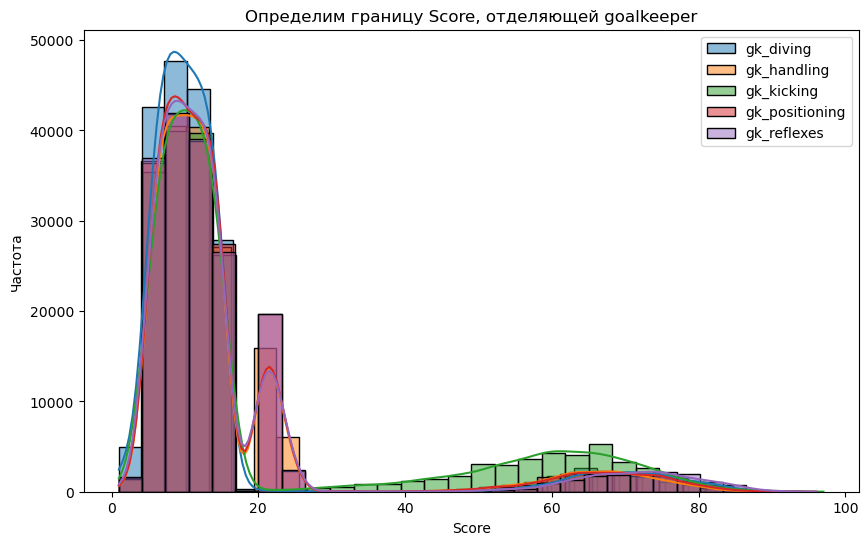

In [13]:
players_gk_columns = [col for col in players_score_columns if col.startswith('gk_')]
players_non_gk_columns = players_score_columns.difference(players_gk_columns)

plt.figure(figsize=(10, 6))

for column in players_gk_columns:
    sns.histplot(players[column], bins=30, kde=True, label=column)

plt.title('Определим границу Score, отделяющей goalkeeper')
plt.xlabel('Score')
plt.ylabel('Частота')
plt.legend()
plt.show()


In [14]:
gk_criteria = 40
players['is_gk'] = (players['gk_positioning'] > gk_criteria) & \
                   (players['gk_reflexes'] > gk_criteria) & \
                   (players['gk_diving'] > gk_criteria) & \
                   (players['gk_handling'] > gk_criteria)

In [15]:
missing_players_values = players.select_dtypes(include='float').isnull().sum()
missing_players_percentage = (missing_players_values / players.shape[0]) * 100
missing_players_percentage.sort_values(ascending=False)

vision                1.474633
jumping               1.474633
balance               1.474633
volleys               1.474633
sliding_tackle        1.474633
curve                 1.474633
agility               1.474633
overall_rating        0.454402
aggression            0.454402
interceptions         0.454402
positioning           0.454402
marking               0.454402
penalties             0.454402
strength              0.454402
standing_tackle       0.454402
gk_diving             0.454402
gk_handling           0.454402
gk_kicking            0.454402
gk_positioning        0.454402
long_shots            0.454402
shot_power            0.454402
stamina               0.454402
potential             0.454402
reactions             0.454402
sprint_speed          0.454402
acceleration          0.454402
ball_control          0.454402
long_passing          0.454402
free_kick_accuracy    0.454402
dribbling             0.454402
short_passing         0.454402
heading_accuracy      0.454402
finishin

In [16]:
players_columns_to_fill = missing_players_percentage[missing_players_percentage > 0].index
mean_players_values = players[players_columns_to_fill].mean()
players[players_columns_to_fill] = players[missing_players_percentage[missing_players_percentage > 0].index].fillna(
    mean_players_values)

In [17]:
def calculate_player_score(row):
    if row['is_gk']:
        return row[players_gk_columns].mean().round(2)
    return row[players_non_gk_columns].mean().round(2)


players['player_score'] = players.apply(calculate_player_score, axis=1)

In [18]:
players.columns

Index(['player_api_id', 'player_name', 'birthday', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'volleys', 'dribbling', 'curve', 'free_kick_accuracy',
       'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
       'agility', 'reactions', 'balance', 'shot_power', 'jumping', 'stamina',
       'strength', 'long_shots', 'aggression', 'interceptions', 'positioning',
       'vision', 'penalties', 'marking', 'standing_tackle', 'sliding_tackle',
       'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning',
       'gk_reflexes', 'player_year', 'is_gk', 'player_score'],
      dtype='object')

In [19]:
# Выбираем необходимые колонки из таблицы players
players_df = players[['player_api_id',
                      'player_name',
                      'player_year',
                      'overall_rating',
                      'potential',
                      'preferred_foot',
                      'attacking_work_rate',
                      'defensive_work_rate', 
                      'crossing', 
                      'finishing', 
                      'heading_accuracy',
                      'short_passing', 
                      'dribbling', 
                      'ball_control', 
                      'acceleration', 
                      'sprint_speed',
                      'stamina',
                      'strength',
                      'positioning',
                      'vision',
                      'penalties',
                      'marking',
                      'standing_tackle',
                      'sliding_tackle'
                     ]]

players_df.head()

,player_api_id,player_name,player_year,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,...,acceleration,sprint_speed,stamina,strength,positioning,vision,penalties,marking,standing_tackle,sliding_tackle
0,505942,Aaron Appindangoye,2016,67.0,71.0,right,medium,medium,49.0,44.0,...,60.0,64.0,54.0,76.0,45.0,54.0,48.0,65.0,69.0,69.0
1,505942,Aaron Appindangoye,2015,67.0,71.0,right,medium,medium,49.0,44.0,...,60.0,64.0,54.0,76.0,45.0,54.0,48.0,65.0,69.0,69.0
2,505942,Aaron Appindangoye,2015,62.0,66.0,right,medium,medium,49.0,44.0,...,60.0,64.0,54.0,76.0,45.0,54.0,48.0,65.0,66.0,69.0
3,505942,Aaron Appindangoye,2015,61.0,65.0,right,medium,medium,48.0,43.0,...,60.0,64.0,54.0,76.0,44.0,53.0,47.0,62.0,63.0,66.0
4,505942,Aaron Appindangoye,2007,61.0,65.0,right,medium,medium,48.0,43.0,...,60.0,64.0,54.0,76.0,44.0,53.0,47.0,62.0,63.0,66.0


In [20]:
players = players[['player_api_id', 'player_year', 'overall_rating', 'player_score']]

players.head(2)

,player_api_id,player_year,overall_rating,player_score
0,505942,2016,67.0,57.3
1,505942,2015,67.0,57.3


In [21]:
players.shape

(183978, 4)

In [22]:
teams.head(4)

,team_api_id,team_long_name,team_short_name,defenceTeamWidthClass,defenceTeamWidth,defencePressureClass,defencePressure,defenceDefenderLineClass,defenceAggressionClass,defenceAggression,...,chanceCreationPassing,chanceCreationCrossingClass,chanceCreationCrossing,buildUpPlaySpeedClass,buildUpPlaySpeed,buildUpPlayPositioningClass,buildUpPlayPassingClass,buildUpPlayPassing,buildUpPlayDribblingClass,buildUpPlayDribbling
0,9930,FC Aarau,AAR,Normal,45,Medium,50,Cover,Press,55,...,60,Normal,65,Balanced,60,Organised,Mixed,50,Little,NaN
1,9930,FC Aarau,AAR,Normal,54,Medium,47,Cover,Press,44,...,54,Normal,63,Balanced,52,Organised,Mixed,56,Normal,48.0
2,9930,FC Aarau,AAR,Normal,54,Medium,47,Cover,Press,44,...,54,Normal,63,Balanced,47,Organised,Mixed,54,Normal,41.0
3,8485,Aberdeen,ABE,Wide,70,Medium,60,Cover,Double,70,...,70,Lots,70,Fast,70,Organised,Long,70,Little,NaN


In [23]:
teams['date'] = teams['date'].astype('datetime64[ns]')

In [24]:
teams['team_year'] = teams['date'].dt.year

In [25]:
teams['team_long_name'].replace(regex='^\d\.\s', value='', inplace=True)

In [26]:
teams_score = teams.select_dtypes(include=['float', 'int'])
((teams_score < 0).any(), (teams_score > 100).any())

(team_api_id               False
 defenceTeamWidth          False
 defencePressure           False
 defenceAggression         False
 chanceCreationShooting    False
 chanceCreationPassing     False
 chanceCreationCrossing    False
 buildUpPlaySpeed          False
 buildUpPlayPassing        False
 buildUpPlayDribbling      False
 team_year                 False
 dtype: bool,
 team_api_id                True
 defenceTeamWidth          False
 defencePressure           False
 defenceAggression         False
 chanceCreationShooting    False
 chanceCreationPassing     False
 chanceCreationCrossing    False
 buildUpPlaySpeed          False
 buildUpPlayPassing        False
 buildUpPlayDribbling      False
 team_year                  True
 dtype: bool)

In [27]:
missing_teams_values = teams.isnull().sum()
missing_teams_percentage = (missing_teams_values / teams.shape[0]) * 100
missing_teams_percentage.sort_values(ascending=False)

buildUpPlayDribbling              66.460905
team_api_id                        0.000000
team_long_name                     0.000000
buildUpPlayDribblingClass          0.000000
buildUpPlayPassing                 0.000000
buildUpPlayPassingClass            0.000000
buildUpPlayPositioningClass        0.000000
buildUpPlaySpeed                   0.000000
buildUpPlaySpeedClass              0.000000
chanceCreationCrossing             0.000000
chanceCreationCrossingClass        0.000000
chanceCreationPassing              0.000000
chanceCreationPassingClass         0.000000
chanceCreationPositioningClass     0.000000
chanceCreationShooting             0.000000
chanceCreationShootingClass        0.000000
date                               0.000000
defenceAggression                  0.000000
defenceAggressionClass             0.000000
defenceDefenderLineClass           0.000000
defencePressure                    0.000000
defencePressureClass               0.000000
defenceTeamWidth                

In [28]:
teams_columns_to_delete = missing_teams_percentage[missing_teams_percentage > 0].index
teams.drop(columns=teams_columns_to_delete, inplace=True)
teams_score_columns = teams.select_dtypes(include=['float', 'int']).columns

In [29]:
teams['team_score'] = teams[
    ['defenceTeamWidth', 'defencePressure', 'defenceAggression', 'chanceCreationShooting',
     'chanceCreationPassing', 'chanceCreationCrossing', 'buildUpPlaySpeed', 'buildUpPlayPassing']].mean(axis=1).round(2)

In [30]:
teams.head(2)

,team_api_id,team_long_name,team_short_name,defenceTeamWidthClass,defenceTeamWidth,defencePressureClass,defencePressure,defenceDefenderLineClass,defenceAggressionClass,defenceAggression,...,chanceCreationCrossingClass,chanceCreationCrossing,buildUpPlaySpeedClass,buildUpPlaySpeed,buildUpPlayPositioningClass,buildUpPlayPassingClass,buildUpPlayPassing,buildUpPlayDribblingClass,team_year,team_score
0,9930,FC Aarau,AAR,Normal,45,Medium,50,Cover,Press,55,...,Normal,65,Balanced,60,Organised,Mixed,50,Little,2010,55.00
1,9930,FC Aarau,AAR,Normal,54,Medium,47,Cover,Press,44,...,Normal,63,Balanced,52,Organised,Mixed,56,Normal,2014,54.25


In [31]:
teams.columns

Index(['team_api_id', 'team_long_name', 'team_short_name',
       'defenceTeamWidthClass', 'defenceTeamWidth', 'defencePressureClass',
       'defencePressure', 'defenceDefenderLineClass', 'defenceAggressionClass',
       'defenceAggression', 'date', 'chanceCreationShootingClass',
       'chanceCreationShooting', 'chanceCreationPositioningClass',
       'chanceCreationPassingClass', 'chanceCreationPassing',
       'chanceCreationCrossingClass', 'chanceCreationCrossing',
       'buildUpPlaySpeedClass', 'buildUpPlaySpeed',
       'buildUpPlayPositioningClass', 'buildUpPlayPassingClass',
       'buildUpPlayPassing', 'buildUpPlayDribblingClass', 'team_year',
       'team_score'],
      dtype='object')

In [32]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   team_api_id                     1458 non-null   int64         
 1   team_long_name                  1458 non-null   object        
 2   team_short_name                 1458 non-null   object        
 3   defenceTeamWidthClass           1458 non-null   object        
 4   defenceTeamWidth                1458 non-null   int64         
 5   defencePressureClass            1458 non-null   object        
 6   defencePressure                 1458 non-null   int64         
 7   defenceDefenderLineClass        1458 non-null   object        
 8   defenceAggressionClass          1458 non-null   object        
 9   defenceAggression               1458 non-null   int64         
 10  date                            1458 non-null   datetime64[ns]
 11  chan

In [33]:
teams.defencePressureClass.value_counts()

defencePressureClass
Medium    1243
Deep       154
High        61
Name: count, dtype: int64

In [34]:
teams.defenceTeamWidthClass.value_counts()

defenceTeamWidthClass
Normal    1286
Wide       111
Narrow      61
Name: count, dtype: int64

In [35]:
teams.defenceDefenderLineClass.value_counts()

defenceDefenderLineClass
Cover           1362
Offside Trap      96
Name: count, dtype: int64

In [36]:
teams.defenceAggressionClass.value_counts()

defenceAggressionClass
Press      1274
Double       99
Contain      85
Name: count, dtype: int64

In [37]:
teams=teams[['team_api_id', 'team_year', 'team_long_name', 'team_short_name', 'team_score','defenceTeamWidth', 'defencePressure', 'defenceAggression', 'chanceCreationShooting',
     'chanceCreationPassing', 'chanceCreationCrossing', 'buildUpPlaySpeed', 'buildUpPlayPassing']]

In [38]:
teams

,team_api_id,team_year,team_long_name,team_short_name,team_score,defenceTeamWidth,defencePressure,defenceAggression,chanceCreationShooting,chanceCreationPassing,chanceCreationCrossing,buildUpPlaySpeed,buildUpPlayPassing
0,9930,2010,FC Aarau,AAR,55.00,45,50,55,55,60,65,60,50
1,9930,2014,FC Aarau,AAR,54.25,54,47,44,64,54,63,52,56
2,9930,2015,FC Aarau,AAR,53.38,54,47,44,64,54,63,47,54
3,8485,2010,Aberdeen,ABE,68.75,70,60,70,70,70,70,70,70
4,8485,2011,Aberdeen,ABE,49.75,52,47,47,52,53,48,47,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,10000,2011,SV Zulte-Waregem,ZUL,50.50,53,46,48,53,52,48,52,52
1454,10000,2012,SV Zulte-Waregem,ZUL,50.75,53,44,55,50,47,52,54,51
1455,10000,2013,SV Zulte-Waregem,ZUL,46.88,37,44,58,32,47,52,54,51
1456,10000,2014,SV Zulte-Waregem,ZUL,46.88,37,44,58,32,47,52,54,51


In [39]:
teams_full=teams

In [40]:
# Выбираем необходимые колонки из таблицы teams
teams_df = teams[['team_api_id', 
                  'team_long_name', 
                  'team_year',
                  'team_score', 
                  'defenceTeamWidth',
                  'defencePressure',
                  'defenceAggression',
                  'chanceCreationShooting', 
                  'chanceCreationPassing', 
                  'chanceCreationCrossing', 
                  'buildUpPlaySpeed', 
                  'buildUpPlayPassing'
                 ]]

teams_df.head()


,team_api_id,team_long_name,team_year,team_score,defenceTeamWidth,defencePressure,defenceAggression,chanceCreationShooting,chanceCreationPassing,chanceCreationCrossing,buildUpPlaySpeed,buildUpPlayPassing
0,9930,FC Aarau,2010,55.00,45,50,55,55,60,65,60,50
1,9930,FC Aarau,2014,54.25,54,47,44,64,54,63,52,56
2,9930,FC Aarau,2015,53.38,54,47,44,64,54,63,47,54
3,8485,Aberdeen,2010,68.75,70,60,70,70,70,70,70,70
4,8485,Aberdeen,2011,49.75,52,47,47,52,53,48,47,52


In [41]:
matches.head(4)

,id,country_name,league_name,season,stage,date,card,match_api_id,home_team_api_id,away_team_api_id,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,None,492473,9987,9993,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,None,492474,10000,9994,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16 00:00:00,None,492475,9984,8635,...,2.5,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17 00:00:00,None,492476,9991,9998,...,7.5,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50


In [42]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Data columns (total 64 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                25979 non-null  int64  
 1   country_name      25979 non-null  object 
 2   league_name       25979 non-null  object 
 3   season            25979 non-null  object 
 4   stage             25979 non-null  int64  
 5   date              25979 non-null  object 
 6   card              14217 non-null  object 
 7   match_api_id      25979 non-null  int64  
 8   home_team_api_id  25979 non-null  int64  
 9   away_team_api_id  25979 non-null  int64  
 10  home_team_goal    25979 non-null  int64  
 11  away_team_goal    25979 non-null  int64  
 12  home_player_1     24755 non-null  float64
 13  home_player_2     24664 non-null  float64
 14  home_player_3     24698 non-null  float64
 15  home_player_4     24656 non-null  float64
 16  home_player_5     24663 non-null  float6

In [43]:
matches['date'] = matches['date'].astype('datetime64[ns]')

In [44]:
matches['match_year'] = matches['date'].dt.year

In [45]:
missing_matches_values = matches.isnull().sum()
missing_matches_percentage = (missing_matches_values / matches.shape[0]) * 100
missing_matches_percentage.sort_values(ascending=False)

PSD            57.011432
PSA            57.011432
PSH            57.011432
BSA            45.490589
BSD            45.490589
                 ...    
date            0.000000
stage           0.000000
season          0.000000
league_name     0.000000
match_year      0.000000
Length: 65, dtype: float64

In [46]:
rows_to_drop_h = matches.filter(regex='^\w{2}H$').isnull().all(axis=1)
rows_to_drop_d = matches.filter(regex='^\w{2}D$').isnull().all(axis=1)
rows_to_drop_a = matches.filter(regex='^\w{2}A$').isnull().all(axis=1)

rows_to_drop = rows_to_drop_h | rows_to_drop_d | rows_to_drop_a

matches.drop(matches[rows_to_drop].index, inplace=True)

In [47]:
matches

,id,country_name,league_name,season,stage,date,card,match_api_id,home_team_api_id,away_team_api_id,...,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,match_year
0,1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,None,492473,9987,9993,...,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,2008
1,2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,None,492474,10000,9994,...,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,2008
2,3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,None,492475,9984,8635,...,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,2008
3,4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,None,492476,9991,9998,...,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50,2008
4,5,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,None,492477,7947,9985,...,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24552,24553,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-25,<card><value><comment>y</comment><stats><ycard...,2030167,9906,10267,...,1.57,4.00,7.00,NaN,NaN,NaN,NaN,NaN,NaN,2015
24553,24554,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,<card><value><comment>y</comment><stats><ycard...,2030168,9864,9783,...,2.30,3.40,3.40,NaN,NaN,NaN,NaN,NaN,NaN,2015
24554,24555,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-26,<card><value><comment>y</comment><stats><ycard...,2030169,8315,9869,...,1.55,4.20,7.00,NaN,NaN,NaN,NaN,NaN,NaN,2015
24555,24556,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,<card><value><comment>y</comment><stats><ycard...,2030170,7878,8603,...,2.30,3.40,3.30,NaN,NaN,NaN,NaN,NaN,NaN,2015


In [48]:
def transform_card(row):
    if pd.isnull(row['card']):
        return 0, 0

    try:
        root = ET.fromstring(row['card'])
    except ET.ParseError:
        return 0, 0

    red_cards = root.findall(".//value[card_type='r']")
    red_card_info = []

    for card in red_cards:
        team_id = card.find('team').text if card.find('team') is not None else 'Unknown'
        red_card_info.append(team_id)

    home_team_cards = sum(1 for team_id in red_card_info if team_id == str(row['home_team_api_id']))
    away_team_cards = sum(1 for team_id in red_card_info if team_id == str(row['away_team_api_id']))

    return home_team_cards, away_team_cards


matches[['home_team_red_cards', 'away_team_red_cards']] = matches.apply(transform_card, axis=1, result_type='expand')


In [49]:
matches

,id,country_name,league_name,season,stage,date,card,match_api_id,home_team_api_id,away_team_api_id,...,VCA,GBH,GBD,GBA,BSH,BSD,BSA,match_year,home_team_red_cards,away_team_red_cards
0,1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,None,492473,9987,9993,...,4.50,1.78,3.25,4.00,1.73,3.40,4.20,2008,0,0
1,2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,None,492474,10000,9994,...,3.25,1.85,3.25,3.75,1.91,3.25,3.60,2008,0,0
2,3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,None,492475,9984,8635,...,2.65,2.50,3.20,2.50,2.30,3.20,2.75,2008,0,0
3,4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,None,492476,9991,9998,...,6.50,1.50,3.75,5.50,1.44,3.75,6.50,2008,0,0
4,5,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,None,492477,7947,9985,...,1.65,4.50,3.50,1.65,4.75,3.30,1.67,2008,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24552,24553,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-25,<card><value><comment>y</comment><stats><ycard...,2030167,9906,10267,...,7.00,NaN,NaN,NaN,NaN,NaN,NaN,2015,0,0
24553,24554,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,<card><value><comment>y</comment><stats><ycard...,2030168,9864,9783,...,3.40,NaN,NaN,NaN,NaN,NaN,NaN,2015,0,0
24554,24555,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-26,<card><value><comment>y</comment><stats><ycard...,2030169,8315,9869,...,7.00,NaN,NaN,NaN,NaN,NaN,NaN,2015,0,0
24555,24556,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,<card><value><comment>y</comment><stats><ycard...,2030170,7878,8603,...,3.30,NaN,NaN,NaN,NaN,NaN,NaN,2015,0,0


In [50]:
matches_full=matches

In [51]:
matches.columns

Index(['id', 'country_name', 'league_name', 'season', 'stage', 'date', 'card',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10',
       'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3',
       'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7',
       'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11',
       'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
       'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
       'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD',
       'BSA', 'match_year', 'home_team_red_cards', 'away_team_red_cards'],
      dtype='object')

In [52]:
matches_df = matches[['match_api_id', 
                      'season', 
                      'match_year',
                      'date', 
                      'home_team_api_id', 
                      'away_team_api_id', 
                      'home_team_goal', 
                      'away_team_goal', 
                      'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 
                      'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11']]

matches_df.head()

,match_api_id,season,match_year,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
0,492473,2008/2009,2008,2008-08-17,9987,9993,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,492474,2008/2009,2008,2008-08-16,10000,9994,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,492475,2008/2009,2008,2008-08-16,9984,8635,0,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,492476,2008/2009,2008,2008-08-17,9991,9998,5,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,492477,2008/2009,2008,2008-08-16,7947,9985,1,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
df = matches.merge(teams, how='left',
                   left_on=['home_team_api_id', 'match_year'],
                   right_on=['team_api_id', 'team_year']) \
    .merge(
    teams, how='left', left_on=['away_team_api_id', 'match_year'], right_on=['team_api_id', 'team_year'],
    suffixes=('_home', '_away')).rename(
    columns={'team_score_home': 'home_team_score', 'team_score_away': 'away_team_score'})

In [54]:
player_columns = [col for col in matches.columns if 'home_player_' in col or 'away_player_' in col]

df.dropna(subset=['team_long_name_away', 'team_long_name_home'], inplace=True)
df.dropna(subset=player_columns, inplace=True)

In [55]:
df.columns

Index(['id', 'country_name', 'league_name', 'season', 'stage', 'date', 'card',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10',
       'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3',
       'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7',
       'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11',
       'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
       'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
       'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD',
       'BSA', 'match_year', 'home_team_red_cards', 'away_team_red_cards',
       'team_api_id_home', 'team_year_home', 'team_long_name_home',
       'team_short_name_home',

In [56]:
df

,id,country_name,league_name,season,stage,date,card,match_api_id,home_team_api_id,away_team_api_id,...,team_short_name_away,away_team_score,defenceTeamWidth_away,defencePressure_away,defenceAggression_away,chanceCreationShooting_away,chanceCreationPassing_away,chanceCreationCrossing_away,buildUpPlaySpeed_away,buildUpPlayPassing_away
373,377,Belgium,Belgium Jupiler League,2009/2010,19,2010-02-03,None,665626,8635,8342,...,CLB,51.88,70.0,60.0,70.0,45.0,45.0,50.0,35.0,40.0
378,382,Belgium,Belgium Jupiler League,2009/2010,19,2010-02-02,None,665634,8203,9993,...,BAC,51.88,70.0,70.0,70.0,50.0,45.0,40.0,35.0,35.0
402,406,Belgium,Belgium Jupiler League,2009/2010,22,2010-01-17,None,665666,9985,8635,...,AND,56.88,70.0,70.0,50.0,60.0,70.0,50.0,50.0,35.0
407,411,Belgium,Belgium Jupiler League,2009/2010,22,2010-01-17,None,665672,9993,9984,...,CEB,55.62,70.0,65.0,60.0,55.0,70.0,45.0,45.0,35.0
408,412,Belgium,Belgium Jupiler League,2009/2010,23,2010-01-24,None,665674,9987,8342,...,CLB,51.88,70.0,60.0,70.0,45.0,45.0,50.0,35.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22592,24553,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-25,<card><value><comment>y</comment><stats><ycard...,2030167,9906,10267,...,VAL,45.38,53.0,49.0,45.0,58.0,37.0,51.0,35.0,35.0
22593,24554,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,<card><value><comment>y</comment><stats><ycard...,2030168,9864,9783,...,COR,49.88,59.0,45.0,50.0,55.0,38.0,52.0,53.0,47.0
22594,24555,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-26,<card><value><comment>y</comment><stats><ycard...,2030169,8315,9869,...,SPG,50.50,41.0,45.0,54.0,38.0,62.0,59.0,55.0,50.0
22595,24556,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,<card><value><comment>y</comment><stats><ycard...,2030170,7878,8603,...,BET,52.00,58.0,58.0,49.0,53.0,59.0,43.0,59.0,37.0


In [57]:
home_player_columns = [col for col in matches.columns if 'home_player' in col]
away_player_columns = [col for col in matches.columns if 'away_player' in col]

rating_score_dict = players.set_index(['player_api_id', 'player_year'])[['overall_rating', 'player_score']].apply(tuple,
                                                                                                                  axis=1).to_dict()

for column in player_columns:
    df[column + '_rating'] = df.apply(
        lambda row: rating_score_dict.get((row[column], row['match_year']), (None, None))[0], axis=1)
    df[column + '_score'] = df.apply(
        lambda row: rating_score_dict.get((row[column], row['match_year']), (None, None))[1], axis=1)

df['home_players_average_rating'] = df[[col + '_rating' for col in player_columns if 'home' in col]].mean(
    axis=1).round(2)
df['away_players_average_rating'] = df[[col + '_rating' for col in player_columns if 'away' in col]].mean(
    axis=1).round(2)
df['home_players_average_score'] = df[[col + '_score' for col in player_columns if 'home' in col]].mean(axis=1).round(
    2)
df['away_players_average_score'] = df[[col + '_score' for col in player_columns if 'away' in col]].mean(axis=1).round(
    2)

df.drop(columns=[col + '_rating' for col in player_columns] + [col + '_score' for col in player_columns], inplace=True)


In [58]:
df['match_result'] = (df['home_team_goal'] - df['away_team_goal']).apply(lambda value: 1 if value > 0 else (-1 if value < 0 else 0))

In [59]:
df

,id,country_name,league_name,season,stage,date,card,match_api_id,home_team_api_id,away_team_api_id,...,chanceCreationShooting_away,chanceCreationPassing_away,chanceCreationCrossing_away,buildUpPlaySpeed_away,buildUpPlayPassing_away,home_players_average_rating,away_players_average_rating,home_players_average_score,away_players_average_score,match_result
373,377,Belgium,Belgium Jupiler League,2009/2010,19,2010-02-03,None,665626,8635,8342,...,45.0,45.0,50.0,35.0,40.0,72.18,70.09,65.96,65.33,1
378,382,Belgium,Belgium Jupiler League,2009/2010,19,2010-02-02,None,665634,8203,9993,...,50.0,45.0,40.0,35.0,35.0,64.00,66.27,59.68,61.71,1
402,406,Belgium,Belgium Jupiler League,2009/2010,22,2010-01-17,None,665666,9985,8635,...,60.0,70.0,50.0,50.0,35.0,71.73,72.18,66.78,65.96,-1
407,411,Belgium,Belgium Jupiler League,2009/2010,22,2010-01-17,None,665672,9993,9984,...,55.0,70.0,45.0,45.0,35.0,66.64,65.18,61.91,60.52,-1
408,412,Belgium,Belgium Jupiler League,2009/2010,23,2010-01-24,None,665674,9987,8342,...,45.0,45.0,50.0,35.0,40.0,66.09,69.91,60.71,64.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22592,24553,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-25,<card><value><comment>y</comment><stats><ycard...,2030167,9906,10267,...,58.0,37.0,51.0,35.0,35.0,80.64,74.82,71.14,67.99,1
22593,24554,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,<card><value><comment>y</comment><stats><ycard...,2030168,9864,9783,...,55.0,38.0,52.0,53.0,47.0,73.00,73.45,65.41,65.31,1
22594,24555,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-26,<card><value><comment>y</comment><stats><ycard...,2030169,8315,9869,...,38.0,62.0,59.0,55.0,50.0,77.18,69.27,67.86,63.25,1
22595,24556,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,<card><value><comment>y</comment><stats><ycard...,2030170,7878,8603,...,53.0,59.0,43.0,59.0,37.0,72.36,72.18,65.02,62.55,0


In [60]:
df.columns

Index(['id', 'country_name', 'league_name', 'season', 'stage', 'date', 'card',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10',
       'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3',
       'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7',
       'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11',
       'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
       'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
       'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD',
       'BSA', 'match_year', 'home_team_red_cards', 'away_team_red_cards',
       'team_api_id_home', 'team_year_home', 'team_long_name_home',
       'team_short_name_home',

In [61]:
in_model=['date',
          'home_team_goal',
          'away_team_goal',
          'match_result',
          'home_team_red_cards',
          'away_team_red_cards',
          'home_team_score', 
          'defenceTeamWidth_home',
          'defencePressure_home',
          'defenceAggression_home',
          'chanceCreationShooting_home',
          'chanceCreationPassing_home',
          'chanceCreationCrossing_home',
          'buildUpPlaySpeed_home',
          'buildUpPlayPassing_home',
          'away_team_score',
          'defenceTeamWidth_away',
          'defencePressure_away',
          'defenceAggression_away',
          'chanceCreationShooting_away',
          'chanceCreationPassing_away',
          'chanceCreationCrossing_away',
          'buildUpPlaySpeed_away',
          'buildUpPlayPassing_away',
          'home_players_average_rating',
          'away_players_average_rating',
          'home_players_average_score',
          'away_players_average_score',
          'B365H', 'B365A', 
          'BWH', 'BWA',
          'IWH', 'IWA', 
          'LBH', 'LBA', 
          'PSA', 
          'WHA', 
          'VCA'
         ]

In [62]:
df[in_model]

,date,home_team_goal,away_team_goal,match_result,home_team_red_cards,away_team_red_cards,home_team_score,defenceTeamWidth_home,defencePressure_home,defenceAggression_home,...,B365A,BWH,BWA,IWH,IWA,LBH,LBA,PSA,WHA,VCA
373,2010-02-03,3,2,1,0,0,56.88,70.0,70.0,50.0,...,4.75,1.75,4.25,1.75,3.80,1.66,4.33,NaN,5.0,4.50
378,2010-02-02,1,0,1,0,0,56.88,60.0,60.0,70.0,...,2.90,2.35,2.80,2.20,2.80,2.30,2.60,NaN,3.0,2.88
402,2010-01-17,0,4,-1,0,0,59.12,65.0,70.0,70.0,...,2.38,2.75,2.40,2.45,2.45,2.60,2.37,NaN,2.4,2.30
407,2010-01-17,1,4,-1,0,0,51.88,70.0,70.0,70.0,...,5.00,1.65,4.90,1.70,3.80,1.66,4.50,NaN,4.5,4.75
408,2010-01-24,2,0,1,0,0,55.00,70.0,70.0,65.0,...,2.30,3.30,2.05,3.00,2.00,2.80,2.20,NaN,2.2,2.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22592,2015-10-25,2,1,1,0,0,52.75,52.0,49.0,42.0,...,6.50,1.57,6.50,1.65,4.90,1.57,6.50,7.06,7.0,7.00
22593,2015-10-24,2,0,1,0,0,43.12,52.0,47.0,37.0,...,3.40,2.35,3.10,2.20,3.20,2.25,3.25,3.36,3.1,3.40
22594,2015-10-26,3,0,1,0,0,48.38,50.0,49.0,57.0,...,7.00,1.55,6.50,1.60,5.40,1.50,6.50,6.95,7.0,7.00
22595,2015-10-24,1,1,0,0,0,55.75,62.0,48.0,45.0,...,3.25,2.35,3.00,2.40,2.75,2.30,3.10,3.35,3.1,3.30


In [63]:
df[in_model].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14916 entries, 373 to 22596
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         14916 non-null  datetime64[ns]
 1   home_team_goal               14916 non-null  int64         
 2   away_team_goal               14916 non-null  int64         
 3   match_result                 14916 non-null  int64         
 4   home_team_red_cards          14916 non-null  int64         
 5   away_team_red_cards          14916 non-null  int64         
 6   home_team_score              14916 non-null  float64       
 7   defenceTeamWidth_home        14916 non-null  float64       
 8   defencePressure_home         14916 non-null  float64       
 9   defenceAggression_home       14916 non-null  float64       
 10  chanceCreationShooting_home  14916 non-null  float64       
 11  chanceCreationPassing_home   14916 non-null 

In [64]:
df[in_model].corr()

,date,home_team_goal,away_team_goal,match_result,home_team_red_cards,away_team_red_cards,home_team_score,defenceTeamWidth_home,defencePressure_home,defenceAggression_home,...,B365A,BWH,BWA,IWH,IWA,LBH,LBA,PSA,WHA,VCA
date,1.000000,-0.019061,0.014097,-0.029350,0.013295,0.003402,-0.126299,-0.057122,-0.086844,-0.083828,...,0.004578,0.033729,0.001739,0.039563,0.012105,0.051946,0.036063,0.008917,0.014056,0.015076
home_team_goal,-0.019061,1.000000,-0.063681,0.619924,-0.057246,0.092788,0.012950,0.024999,0.084232,0.042463,...,0.358001,-0.261813,0.355351,-0.267428,0.362023,-0.261460,0.351738,0.350217,0.349668,0.347059
away_team_goal,0.014097,-0.063681,1.000000,-0.634832,0.078853,-0.044382,-0.026564,-0.029814,-0.047405,-0.016618,...,-0.227289,0.297301,-0.229986,0.297957,-0.233303,0.295679,-0.228935,-0.231881,-0.221188,-0.215824
match_result,-0.029350,0.619924,-0.634832,1.000000,-0.089246,0.090987,0.027174,0.029118,0.075529,0.032312,...,0.326719,-0.339088,0.329575,-0.342643,0.335466,-0.337642,0.325186,0.324890,0.318741,0.310567
home_team_red_cards,0.013295,-0.057246,0.078853,-0.089246,1.000000,0.094311,0.005454,-0.002546,-0.001791,0.004669,...,-0.022379,0.006358,-0.019908,0.006466,-0.020839,0.006212,-0.018497,-0.022929,-0.020590,-0.019057
away_team_red_cards,0.003402,0.092788,-0.044382,0.090987,0.094311,1.000000,-0.014183,-0.011398,-0.012411,-0.015512,...,0.005034,-0.022167,0.008280,-0.023129,0.008257,-0.021759,0.006081,0.005369,0.006662,0.005519
home_team_score,-0.126299,0.012950,-0.026564,0.027174,0.005454,-0.014183,1.000000,0.476215,0.537180,0.546171,...,0.044070,-0.048619,0.048874,-0.047986,0.047383,-0.042464,0.052808,0.035609,0.039621,0.042316
defenceTeamWidth_home,-0.057122,0.024999,-0.029814,0.029118,-0.002546,-0.011398,0.476215,1.000000,0.496767,0.191304,...,0.093460,-0.051967,0.095720,-0.053887,0.096157,-0.050781,0.088974,0.127201,0.092756,0.093129
defencePressure_home,-0.086844,0.084232,-0.047405,0.075529,-0.001791,-0.012411,0.537180,0.496767,1.000000,0.381980,...,0.188729,-0.112617,0.188592,-0.111012,0.191156,-0.111602,0.188830,0.241856,0.184988,0.186245
defenceAggression_home,-0.083828,0.042463,-0.016618,0.032312,0.004669,-0.015512,0.546171,0.191304,0.381980,1.000000,...,0.089279,-0.063015,0.092254,-0.061029,0.091615,-0.059296,0.099466,0.202822,0.093693,0.094829


In [65]:
in_corr=['home_team_red_cards',
          'away_team_red_cards',
          'home_team_score', 
          'defenceTeamWidth_home',
          'defencePressure_home',
          'defenceAggression_home',
          'chanceCreationShooting_home',
          'chanceCreationPassing_home',
          'chanceCreationCrossing_home',
          'buildUpPlaySpeed_home',
          'buildUpPlayPassing_home',
          'away_team_score',
          'defenceTeamWidth_away',
          'defencePressure_away',
          'defenceAggression_away',
          'chanceCreationShooting_away',
          'chanceCreationPassing_away',
          'chanceCreationCrossing_away',
          'buildUpPlaySpeed_away',
          'buildUpPlayPassing_away',
          'home_players_average_rating',
          'away_players_average_rating',
          'home_players_average_score',
          'away_players_average_score',
          'B365H', 'B365A', 
          'BWH', 'BWA',
          'IWH', 'IWA', 
          'LBH', 'LBA', 
          'PSA', 
          'WHA', 
          'VCA'
         ]

In [66]:
df1=df[in_model]

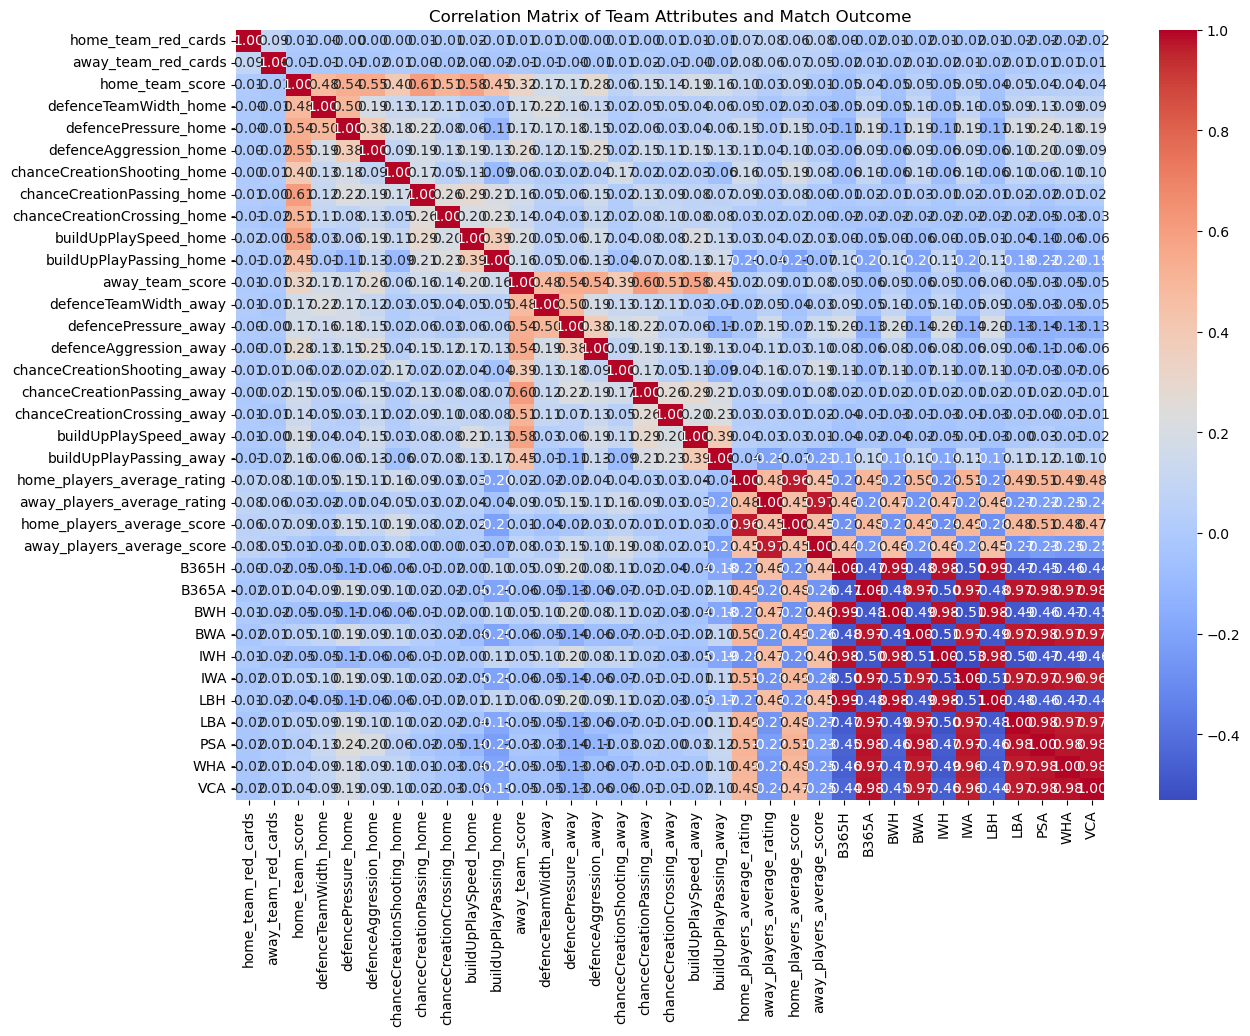

In [67]:
# Выбираем только числовые колонки
correlation_data = df[in_corr]
# Рассчитываем корреляционную матрицу
corr_matrix = correlation_data.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Team Attributes and Match Outcome')
plt.show()

In [68]:
df1=df1.dropna()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8639 entries, 991 to 22596
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         8639 non-null   datetime64[ns]
 1   home_team_goal               8639 non-null   int64         
 2   away_team_goal               8639 non-null   int64         
 3   match_result                 8639 non-null   int64         
 4   home_team_red_cards          8639 non-null   int64         
 5   away_team_red_cards          8639 non-null   int64         
 6   home_team_score              8639 non-null   float64       
 7   defenceTeamWidth_home        8639 non-null   float64       
 8   defencePressure_home         8639 non-null   float64       
 9   defenceAggression_home       8639 non-null   float64       
 10  chanceCreationShooting_home  8639 non-null   float64       
 11  chanceCreationPassing_home   8639 non-null   

In [69]:
# Выборка данных и целевой переменной
X = df1.drop(columns=['date','home_team_goal', 'away_team_goal', 'match_result','home_team_red_cards','away_team_red_cards'])
Y = df1['match_result']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [70]:
# Создание и обучение модели
model = LogisticRegression(max_iter=2000)  # Используем логистическую регрессию с увеличенным количеством итераций
model.fit(X_train, Y_train)

LogisticRegression(max_iter=2000)

In [71]:
# Предсказание на тестовых данных
Y_pred = model.predict(X_test)

# Оценка точности
print('Accuracy: %.2f' % accuracy_score(Y_test, Y_pred))

accuracy = accuracy_score(Y_test, Y_pred)
print(f'Точность модели: {accuracy:.2f}')

# Вывод отчета о классификации
print(classification_report(Y_test, Y_pred))


Accuracy: 0.54
Точность модели: 0.54
              precision    recall  f1-score   support

          -1       0.52      0.51      0.51       787
           0       0.25      0.01      0.02       612
           1       0.56      0.84      0.67      1193

    accuracy                           0.54      2592
   macro avg       0.44      0.45      0.40      2592
weighted avg       0.47      0.54      0.47      2592



In [72]:
df.columns

Index(['id', 'country_name', 'league_name', 'season', 'stage', 'date', 'card',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10',
       'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3',
       'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7',
       'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11',
       'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
       'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
       'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD',
       'BSA', 'match_year', 'home_team_red_cards', 'away_team_red_cards',
       'team_api_id_home', 'team_year_home', 'team_long_name_home',
       'team_short_name_home',

In [73]:
#in_corr1=['home_team_score','defenceTeamWidth_home','defencePressure_home','defenceAggression_home','chanceCreationShooting_home','chanceCreationPassing_home','chanceCreationCrossing_home','buildUpPlaySpeed_home','buildUpPlayPassing_home','away_team_score','defenceTeamWidth_away','defencePressure_away','defenceAggression_away','chanceCreationShooting_away','chanceCreationPassing_away','chanceCreationCrossing_away','buildUpPlaySpeed_away','buildUpPlayPassing_away','home_players_average_rating','away_players_average_rating','home_players_average_score','away_players_average_score']

In [74]:
in_corr1=['home_team_score',
          'away_team_score',
          'home_players_average_rating',
          'away_players_average_rating',
          #'home_players_average_score',
          #'away_players_average_score',
          #'VCA' 
          #'BWH', 'BWA',
          #'IWH', 'IWA', 
          #'LBH', 'LBA', 
          #'PSA', 
          #'WHA', 
          'B365H', 'B365A',
          'home_team_red_cards', 'away_team_red_cards',
          'defenceTeamWidth_home','defencePressure_home','defenceAggression_home',
          #'chanceCreationShooting_home', 'chanceCreationPassing_home','chanceCreationCrossing_home', 
          #'buildUpPlaySpeed_home','buildUpPlayPassing_home',
          'defenceTeamWidth_away', 'defencePressure_away','defenceAggression_away', 
          #'chanceCreationShooting_away','chanceCreationPassing_away', 'chanceCreationCrossing_away',
          #'buildUpPlaySpeed_away', 'buildUpPlayPassing_away'
         ]

In [75]:
# Выборка данных и целевой переменной
X1 = df1[in_corr1]
Y1 = df1['match_result']

# Разделение данных на обучающую и тестовую выборки
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)

In [76]:
# Создание и обучение модели
model1 = LogisticRegression(max_iter=2000, random_state=42, multi_class='multinomial')  # Используем логистическую регрессию с увеличенным количеством итераций
model1.fit(X1_train, Y1_train)
# Предсказание на тестовых данных
Y1_pred = model1.predict(X1_test)

# Оценка точности
print('Accuracy: %.2f' % accuracy_score(Y1_test, Y1_pred))

accuracy = accuracy_score(Y1_test, Y1_pred)
print(f'Точность модели: {accuracy:.2f}')

# Вывод отчета о классификации
print(classification_report(Y1_test, Y1_pred))


Accuracy: 0.57
Точность модели: 0.57
              precision    recall  f1-score   support

          -1       0.54      0.55      0.54       525
           0       0.00      0.00      0.00       390
           1       0.58      0.85      0.69       813

    accuracy                           0.57      1728
   macro avg       0.37      0.47      0.41      1728
weighted avg       0.44      0.57      0.49      1728



In [77]:
in_corr2=['home_team_score', 
          'defenceTeamWidth_home',
          'defencePressure_home',
          'defenceAggression_home',
          'chanceCreationShooting_home',
          'chanceCreationPassing_home',
          'chanceCreationCrossing_home',
          'buildUpPlaySpeed_home',
          'buildUpPlayPassing_home',
          'away_team_score',
          'defenceTeamWidth_away',
          'defencePressure_away',
          'defenceAggression_away',
          'chanceCreationShooting_away',
          'chanceCreationPassing_away',
          'chanceCreationCrossing_away',
          'buildUpPlaySpeed_away',
          'buildUpPlayPassing_away',
          'home_players_average_rating',
          'away_players_average_rating',
          'home_players_average_score',
          'away_players_average_score'
         ]

In [78]:
# Выборка данных и целевой переменной
X2 = df[in_corr2]
Y2 = df['away_team_goal']

# Разделение данных на обучающую и тестовую выборки
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=42)

In [79]:
# Создание и обучение модели
model2 = LogisticRegression(max_iter=2000)  # Используем логистическую регрессию с увеличенным количеством итераций
model2.fit(X2_train, Y2_train)

LogisticRegression(max_iter=2000)

In [80]:
# Предсказание на тестовых данных
Y2_pred = model2.predict(X2_test)

# Оценка точности
print('Accuracy: %.2f' % accuracy_score(Y2_test, Y2_pred))

accuracy = accuracy_score(Y2_test, Y2_pred)
print('\n',f'Точность модели: {accuracy:.2f}')

# Вывод отчета о классификации
print(classification_report(Y2_test, Y2_pred))


Accuracy: 0.38

 Точность модели: 0.38
              precision    recall  f1-score   support

           0       0.45      0.52      0.48       999
           1       0.35      0.58      0.43      1023
           2       0.30      0.05      0.08       605
           3       0.00      0.00      0.00       223
           4       0.00      0.00      0.00        96
           5       0.00      0.00      0.00        23
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2

    accuracy                           0.38      2984
   macro avg       0.12      0.13      0.11      2984
weighted avg       0.33      0.38      0.33      2984



In [81]:
teams_full

,team_api_id,team_year,team_long_name,team_short_name,team_score,defenceTeamWidth,defencePressure,defenceAggression,chanceCreationShooting,chanceCreationPassing,chanceCreationCrossing,buildUpPlaySpeed,buildUpPlayPassing
0,9930,2010,FC Aarau,AAR,55.00,45,50,55,55,60,65,60,50
1,9930,2014,FC Aarau,AAR,54.25,54,47,44,64,54,63,52,56
2,9930,2015,FC Aarau,AAR,53.38,54,47,44,64,54,63,47,54
3,8485,2010,Aberdeen,ABE,68.75,70,60,70,70,70,70,70,70
4,8485,2011,Aberdeen,ABE,49.75,52,47,47,52,53,48,47,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,10000,2011,SV Zulte-Waregem,ZUL,50.50,53,46,48,53,52,48,52,52
1454,10000,2012,SV Zulte-Waregem,ZUL,50.75,53,44,55,50,47,52,54,51
1455,10000,2013,SV Zulte-Waregem,ZUL,46.88,37,44,58,32,47,52,54,51
1456,10000,2014,SV Zulte-Waregem,ZUL,46.88,37,44,58,32,47,52,54,51


In [82]:
players_full

,player_api_id,player_name,birthday,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_year,is_gk,player_score
0,505942,Aaron Appindangoye,1992-02-29,2016-02-18,67.0,71.0,right,medium,medium,49.0,...,69.0,69.0,6.0,11.0,10.0,8.0,8.0,2016,False,57.30
1,505942,Aaron Appindangoye,1992-02-29,2015-11-19,67.0,71.0,right,medium,medium,49.0,...,69.0,69.0,6.0,11.0,10.0,8.0,8.0,2015,False,57.30
2,505942,Aaron Appindangoye,1992-02-29,2015-09-21,62.0,66.0,right,medium,medium,49.0,...,66.0,69.0,6.0,11.0,10.0,8.0,8.0,2015,False,55.63
3,505942,Aaron Appindangoye,1992-02-29,2015-03-20,61.0,65.0,right,medium,medium,48.0,...,63.0,66.0,5.0,10.0,9.0,7.0,7.0,2015,False,54.67
4,505942,Aaron Appindangoye,1992-02-29,2007-02-22,61.0,65.0,right,medium,medium,48.0,...,63.0,66.0,5.0,10.0,9.0,7.0,7.0,2007,False,54.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,39902,Zvjezdan Misimovic,1982-06-05,2009-08-30,83.0,85.0,right,medium,low,84.0,...,31.0,30.0,9.0,20.0,84.0,20.0,20.0,2009,False,72.43
183974,39902,Zvjezdan Misimovic,1982-06-05,2009-02-22,78.0,80.0,right,medium,low,74.0,...,31.0,30.0,9.0,20.0,73.0,20.0,20.0,2009,False,68.93
183975,39902,Zvjezdan Misimovic,1982-06-05,2008-08-30,77.0,80.0,right,medium,low,74.0,...,31.0,30.0,9.0,20.0,73.0,20.0,20.0,2008,False,68.93
183976,39902,Zvjezdan Misimovic,1982-06-05,2007-08-30,78.0,81.0,right,medium,low,74.0,...,32.0,30.0,9.0,20.0,73.0,20.0,20.0,2007,False,67.53


In [83]:
matches_full

,id,country_name,league_name,season,stage,date,card,match_api_id,home_team_api_id,away_team_api_id,...,VCA,GBH,GBD,GBA,BSH,BSD,BSA,match_year,home_team_red_cards,away_team_red_cards
0,1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,None,492473,9987,9993,...,4.50,1.78,3.25,4.00,1.73,3.40,4.20,2008,0,0
1,2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,None,492474,10000,9994,...,3.25,1.85,3.25,3.75,1.91,3.25,3.60,2008,0,0
2,3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,None,492475,9984,8635,...,2.65,2.50,3.20,2.50,2.30,3.20,2.75,2008,0,0
3,4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,None,492476,9991,9998,...,6.50,1.50,3.75,5.50,1.44,3.75,6.50,2008,0,0
4,5,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,None,492477,7947,9985,...,1.65,4.50,3.50,1.65,4.75,3.30,1.67,2008,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24552,24553,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-25,<card><value><comment>y</comment><stats><ycard...,2030167,9906,10267,...,7.00,NaN,NaN,NaN,NaN,NaN,NaN,2015,0,0
24553,24554,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,<card><value><comment>y</comment><stats><ycard...,2030168,9864,9783,...,3.40,NaN,NaN,NaN,NaN,NaN,NaN,2015,0,0
24554,24555,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-26,<card><value><comment>y</comment><stats><ycard...,2030169,8315,9869,...,7.00,NaN,NaN,NaN,NaN,NaN,NaN,2015,0,0
24555,24556,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,<card><value><comment>y</comment><stats><ycard...,2030170,7878,8603,...,3.30,NaN,NaN,NaN,NaN,NaN,NaN,2015,0,0


In [84]:
matches_teams_df = matches_full.merge(teams_full, how='left',
                   left_on=['home_team_api_id', 'match_year'],
                   right_on=['team_api_id', 'team_year']) \
    .merge(
    teams_full, how='left', left_on=['away_team_api_id', 'match_year'], right_on=['team_api_id', 'team_year'],
    suffixes=('_home', '_away')).rename(
    columns={'team_score_home': 'home_team_score', 'team_score_away': 'away_team_score'})

matches_teams_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22597 entries, 0 to 22596
Data columns (total 93 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           22597 non-null  int64         
 1   country_name                 22597 non-null  object        
 2   league_name                  22597 non-null  object        
 3   season                       22597 non-null  object        
 4   stage                        22597 non-null  int64         
 5   date                         22597 non-null  datetime64[ns]
 6   card                         14104 non-null  object        
 7   match_api_id                 22597 non-null  int64         
 8   home_team_api_id             22597 non-null  int64         
 9   away_team_api_id             22597 non-null  int64         
 10  home_team_goal               22597 non-null  int64         
 11  away_team_goal               22597 non-nu

In [85]:
# Создаем список с игроками
players_cols = ['home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 
                'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 
                'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 
                'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 
                'away_player_10', 'away_player_11']

# Функция для добавления рейтинга игрока
def add_player_ratings(matches_teams_df, players_full, player_cols):
    for col in player_cols:
        matches_teams_df[f'{col}_rating'] = matches_teams_df.apply(
            lambda row: players_full[
                (players_full['player_api_id'] == row[col]) & (players_full['date'] <= row['date'])
            ].sort_values('date', ascending=False).iloc[0]['overall_rating'] if not players_full[
                (players_full['player_api_id'] == row[col]) & (players_full['date'] <= row['date'])
            ].empty else None, axis=1)
    return matches_teams_df

# Добавляем данные рейтингов игроков
matches_teams_with_ratings = add_player_ratings(matches_teams_df, players_full, players_cols)

# Проверка результатов
matches_teams_with_ratings

,id,country_name,league_name,season,stage,date,card,match_api_id,home_team_api_id,away_team_api_id,...,away_player_2_rating,away_player_3_rating,away_player_4_rating,away_player_5_rating,away_player_6_rating,away_player_7_rating,away_player_8_rating,away_player_9_rating,away_player_10_rating,away_player_11_rating
0,1,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,None,492473,9987,9993,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,None,492474,10000,9994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,None,492475,9984,8635,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-17,None,492476,9991,9998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Belgium,Belgium Jupiler League,2008/2009,1,2008-08-16,None,492477,7947,9985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22592,24553,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-25,<card><value><comment>y</comment><stats><ycard...,2030167,9906,10267,...,73.0,82.0,80.0,80.0,82.0,79.0,77.0,80.0,79.0,75.0
22593,24554,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,<card><value><comment>y</comment><stats><ycard...,2030168,9864,9783,...,74.0,75.0,77.0,75.0,75.0,77.0,76.0,74.0,73.0,78.0
22594,24555,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-26,<card><value><comment>y</comment><stats><ycard...,2030169,8315,9869,...,76.0,74.0,76.0,73.0,71.0,75.0,73.0,76.0,77.0,72.0
22595,24556,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,<card><value><comment>y</comment><stats><ycard...,2030170,7878,8603,...,73.0,72.0,76.0,71.0,79.0,75.0,71.0,75.0,72.0,79.0


In [86]:
matches_teams_with_ratings.columns

Index(['id', 'country_name', 'league_name', 'season', 'stage', 'date', 'card',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       ...
       'away_player_2_rating', 'away_player_3_rating', 'away_player_4_rating',
       'away_player_5_rating', 'away_player_6_rating', 'away_player_7_rating',
       'away_player_8_rating', 'away_player_9_rating', 'away_player_10_rating',
       'away_player_11_rating'],
      dtype='object', length=115)

In [87]:
matches_teams_with_ratings.isna().mean().sort_values(ascending=False)

PSH                    0.505775
PSD                    0.505775
PSA                    0.505775
card                   0.375846
BSH                    0.373324
                         ...   
away_team_goal         0.000000
home_team_red_cards    0.000000
country_name           0.000000
match_year             0.000000
id                     0.000000
Length: 115, dtype: float64

In [88]:
matches_teams_with_ratings=matches_teams_with_ratings.drop(columns=[ 'B365D', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
       'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
       'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD',
       'BSA','card'])

In [89]:
matches_teams_with_ratings.isna().mean().sort_values(ascending=False)

team_year_away                 0.271408
chanceCreationShooting_away    0.271408
team_api_id_away               0.271408
team_long_name_away            0.271408
team_short_name_away           0.271408
                                 ...   
country_name                   0.000000
away_team_red_cards            0.000000
home_team_red_cards            0.000000
match_year                     0.000000
id                             0.000000
Length: 86, dtype: float64

In [91]:
matches_teams_with_ratings.shape

(22597, 86)

In [92]:
df_full=matches_teams_with_ratings

In [93]:
df_full=df_full.dropna()
df_full

,id,country_name,league_name,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_player_2_rating,away_player_3_rating,away_player_4_rating,away_player_5_rating,away_player_6_rating,away_player_7_rating,away_player_8_rating,away_player_9_rating,away_player_10_rating,away_player_11_rating
373,377,Belgium,Belgium Jupiler League,2009/2010,19,2010-02-03,665626,8635,8342,3,...,69.0,67.0,71.0,67.0,69.0,68.0,70.0,68.0,67.0,69.0
378,382,Belgium,Belgium Jupiler League,2009/2010,19,2010-02-02,665634,8203,9993,1,...,68.0,64.0,64.0,68.0,68.0,64.0,68.0,63.0,66.0,69.0
402,406,Belgium,Belgium Jupiler League,2009/2010,22,2010-01-17,665666,9985,8635,0,...,70.0,73.0,70.0,67.0,72.0,70.0,77.0,74.0,62.0,74.0
407,411,Belgium,Belgium Jupiler League,2009/2010,22,2010-01-17,665672,9993,9984,1,...,64.0,67.0,63.0,66.0,65.0,65.0,50.0,70.0,65.0,64.0
408,412,Belgium,Belgium Jupiler League,2009/2010,23,2010-01-24,665674,9987,8342,2,...,69.0,68.0,65.0,70.0,67.0,69.0,69.0,67.0,71.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22592,24553,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-25,2030167,9906,10267,2,...,73.0,82.0,80.0,80.0,82.0,79.0,77.0,80.0,79.0,75.0
22593,24554,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,2030168,9864,9783,2,...,74.0,75.0,77.0,75.0,75.0,77.0,76.0,74.0,73.0,78.0
22594,24555,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-26,2030169,8315,9869,3,...,76.0,74.0,76.0,73.0,71.0,75.0,73.0,76.0,77.0,72.0
22595,24556,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,2030170,7878,8603,1,...,73.0,72.0,76.0,71.0,79.0,75.0,71.0,75.0,72.0,79.0


In [94]:
df_full['match_result'] = (df_full['home_team_goal'] 
                      - df_full['away_team_goal']).apply(lambda value: 1 if value > 0 else (-1 if value < 0 else 0))

In [95]:
df_full.columns

Index(['id', 'country_name', 'league_name', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10',
       'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3',
       'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7',
       'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11',
       'B365H', 'B365A', 'match_year', 'home_team_red_cards',
       'away_team_red_cards', 'team_api_id_home', 'team_year_home',
       'team_long_name_home', 'team_short_name_home', 'home_team_score',
       'defenceTeamWidth_home', 'defencePressure_home',
       'defenceAggression_home', 'chanceCreationShooting_home',
       'chanceCreationPassing_home', 'chanceCreationCrossing_home',
       'buildUpPlay

In [99]:
duplicates = df_full.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')

Number of duplicate rows: 0


In [100]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14913 entries, 373 to 22596
Data columns (total 87 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           14913 non-null  int64         
 1   country_name                 14913 non-null  object        
 2   league_name                  14913 non-null  object        
 3   season                       14913 non-null  object        
 4   stage                        14913 non-null  int64         
 5   date                         14913 non-null  datetime64[ns]
 6   match_api_id                 14913 non-null  int64         
 7   home_team_api_id             14913 non-null  int64         
 8   away_team_api_id             14913 non-null  int64         
 9   home_team_goal               14913 non-null  int64         
 10  away_team_goal               14913 non-null  int64         
 11  home_player_1                14913 non-null 

In [101]:
# Создание нового признака: средний рейтинг игроков для команд
df_full['home_avg_rating'] = df_full[[f'home_player_{i}_rating' for i in range(1, 12)]].mean(axis=1)
df_full['away_avg_rating'] = df_full[[f'away_player_{i}_rating' for i in range(1, 12)]].mean(axis=1)
df_full

,id,country_name,league_name,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_player_5_rating,away_player_6_rating,away_player_7_rating,away_player_8_rating,away_player_9_rating,away_player_10_rating,away_player_11_rating,match_result,home_avg_rating,away_avg_rating
373,377,Belgium,Belgium Jupiler League,2009/2010,19,2010-02-03,665626,8635,8342,3,...,67.0,69.0,68.0,70.0,68.0,67.0,69.0,1,70.909091,68.909091
378,382,Belgium,Belgium Jupiler League,2009/2010,19,2010-02-02,665634,8203,9993,1,...,68.0,68.0,64.0,68.0,63.0,66.0,69.0,1,62.636364,66.000000
402,406,Belgium,Belgium Jupiler League,2009/2010,22,2010-01-17,665666,9985,8635,0,...,67.0,72.0,70.0,77.0,74.0,62.0,74.0,-1,71.090909,70.909091
407,411,Belgium,Belgium Jupiler League,2009/2010,22,2010-01-17,665672,9993,9984,1,...,66.0,65.0,65.0,50.0,70.0,65.0,64.0,-1,66.545455,63.909091
408,412,Belgium,Belgium Jupiler League,2009/2010,23,2010-01-24,665674,9987,8342,2,...,70.0,67.0,69.0,69.0,67.0,71.0,69.0,1,64.818182,68.818182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22592,24553,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-25,2030167,9906,10267,2,...,80.0,82.0,79.0,77.0,80.0,79.0,75.0,1,81.545455,78.181818
22593,24554,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,2030168,9864,9783,2,...,75.0,75.0,77.0,76.0,74.0,73.0,78.0,1,75.181818,75.454545
22594,24555,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-26,2030169,8315,9869,3,...,73.0,71.0,75.0,73.0,76.0,77.0,72.0,1,79.363636,73.909091
22595,24556,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,2030170,7878,8603,1,...,71.0,79.0,75.0,71.0,75.0,72.0,79.0,0,73.636364,74.545455


In [103]:
# Создание нового признака: разница в рейтинге между командами
df_full['rating_difference'] = df_full['home_avg_rating'] - df_full['away_avg_rating']
df_full

,id,country_name,league_name,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_player_6_rating,away_player_7_rating,away_player_8_rating,away_player_9_rating,away_player_10_rating,away_player_11_rating,match_result,home_avg_rating,away_avg_rating,rating_difference
373,377,Belgium,Belgium Jupiler League,2009/2010,19,2010-02-03,665626,8635,8342,3,...,69.0,68.0,70.0,68.0,67.0,69.0,1,70.909091,68.909091,2.000000
378,382,Belgium,Belgium Jupiler League,2009/2010,19,2010-02-02,665634,8203,9993,1,...,68.0,64.0,68.0,63.0,66.0,69.0,1,62.636364,66.000000,-3.363636
402,406,Belgium,Belgium Jupiler League,2009/2010,22,2010-01-17,665666,9985,8635,0,...,72.0,70.0,77.0,74.0,62.0,74.0,-1,71.090909,70.909091,0.181818
407,411,Belgium,Belgium Jupiler League,2009/2010,22,2010-01-17,665672,9993,9984,1,...,65.0,65.0,50.0,70.0,65.0,64.0,-1,66.545455,63.909091,2.636364
408,412,Belgium,Belgium Jupiler League,2009/2010,23,2010-01-24,665674,9987,8342,2,...,67.0,69.0,69.0,67.0,71.0,69.0,1,64.818182,68.818182,-4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22592,24553,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-25,2030167,9906,10267,2,...,82.0,79.0,77.0,80.0,79.0,75.0,1,81.545455,78.181818,3.363636
22593,24554,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,2030168,9864,9783,2,...,75.0,77.0,76.0,74.0,73.0,78.0,1,75.181818,75.454545,-0.272727
22594,24555,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-26,2030169,8315,9869,3,...,71.0,75.0,73.0,76.0,77.0,72.0,1,79.363636,73.909091,5.454545
22595,24556,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,2030170,7878,8603,1,...,79.0,75.0,71.0,75.0,72.0,79.0,0,73.636364,74.545455,-0.909091


In [143]:
# Количество последних матчей, которые будем учитывать
num_matches = 2

# Создание нового признака: количество побед в домашних и выездных матчах за num_matches
df_full['home_team_recent_home_wins'] = df_full.groupby('home_team_api_id')['match_result'].transform(lambda x: x.rolling(num_matches, min_periods=1).apply(lambda y: (y == 1).sum(), raw=True))
df_full['away_team_recent_away_wins'] = df_full.groupby('away_team_api_id')['match_result'].transform(lambda x: x.rolling(num_matches, min_periods=1).apply(lambda y: (y == -1).sum(), raw=True))
df_full

,id,country_name,league_name,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_avg_rating,rating_difference,home_team_recent_home_wins,away_team_recent_away_wins,home_team_form,away_team_form,home_team_avg_goals_scored,away_team_avg_goals_scored,home_team_avg_goals_conceded,away_team_avg_goals_conceded
373,377,Belgium,Belgium Jupiler League,2009/2010,19,2010-02-03,665626,8635,8342,3,...,68.909091,2.000000,1.0,0.0,1.0,1.0,3.0,2.0,2.0,3.0
378,382,Belgium,Belgium Jupiler League,2009/2010,19,2010-02-02,665634,8203,9993,1,...,66.000000,-3.363636,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
402,406,Belgium,Belgium Jupiler League,2009/2010,22,2010-01-17,665666,9985,8635,0,...,70.909091,0.181818,0.0,1.0,-1.0,-1.0,0.0,4.0,4.0,0.0
407,411,Belgium,Belgium Jupiler League,2009/2010,22,2010-01-17,665672,9993,9984,1,...,63.909091,2.636364,0.0,1.0,-1.0,-1.0,1.0,4.0,4.0,1.0
408,412,Belgium,Belgium Jupiler League,2009/2010,23,2010-01-24,665674,9987,8342,2,...,68.818182,-4.000000,1.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22592,24553,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-25,2030167,9906,10267,2,...,78.181818,3.363636,1.0,0.0,1.0,1.0,2.0,1.0,1.0,2.0
22593,24554,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,2030168,9864,9783,2,...,75.454545,-0.272727,2.0,0.0,1.0,1.0,2.0,0.0,0.0,2.0
22594,24555,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-26,2030169,8315,9869,3,...,73.909091,5.454545,2.0,1.0,1.0,1.0,3.0,0.0,0.0,3.0
22595,24556,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,2030170,7878,8603,1,...,74.545455,-0.909091,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0


In [144]:
# Создание нового признака: учет количества побед, ничьих, поражений команды за num_matches
df_full['home_team_form'] = df_full.groupby('home_team_api_id')['match_result'].transform(lambda x: x.rolling(num_matches, min_periods=1).sum())
df_full['away_team_form'] = df_full.groupby('away_team_api_id')['match_result'].transform(lambda x: x.rolling(num_matches, min_periods=1).sum())
df_full

,id,country_name,league_name,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_avg_rating,rating_difference,home_team_recent_home_wins,away_team_recent_away_wins,home_team_form,away_team_form,home_team_avg_goals_scored,away_team_avg_goals_scored,home_team_avg_goals_conceded,away_team_avg_goals_conceded
373,377,Belgium,Belgium Jupiler League,2009/2010,19,2010-02-03,665626,8635,8342,3,...,68.909091,2.000000,1.0,0.0,1.0,1.0,3.0,2.0,2.0,3.0
378,382,Belgium,Belgium Jupiler League,2009/2010,19,2010-02-02,665634,8203,9993,1,...,66.000000,-3.363636,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
402,406,Belgium,Belgium Jupiler League,2009/2010,22,2010-01-17,665666,9985,8635,0,...,70.909091,0.181818,0.0,1.0,-1.0,-1.0,0.0,4.0,4.0,0.0
407,411,Belgium,Belgium Jupiler League,2009/2010,22,2010-01-17,665672,9993,9984,1,...,63.909091,2.636364,0.0,1.0,-1.0,-1.0,1.0,4.0,4.0,1.0
408,412,Belgium,Belgium Jupiler League,2009/2010,23,2010-01-24,665674,9987,8342,2,...,68.818182,-4.000000,1.0,0.0,1.0,2.0,2.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22592,24553,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-25,2030167,9906,10267,2,...,78.181818,3.363636,1.0,0.0,1.0,2.0,2.0,1.0,1.0,2.0
22593,24554,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,2030168,9864,9783,2,...,75.454545,-0.272727,2.0,0.0,2.0,1.0,2.0,0.0,0.0,2.0
22594,24555,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-26,2030169,8315,9869,3,...,73.909091,5.454545,2.0,1.0,2.0,0.0,3.0,0.0,0.0,3.0
22595,24556,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,2030170,7878,8603,1,...,74.545455,-0.909091,0.0,1.0,0.0,-1.0,1.0,1.0,1.0,1.0


In [145]:
# Создание нового признака: cреднее количество голов, забитых и пропущенных командой за num_matches
df_full['home_team_avg_goals_scored'] = df_full.groupby('home_team_api_id')['home_team_goal'].transform(lambda x: x.rolling(num_matches, min_periods=1).mean())
df_full['away_team_avg_goals_scored'] = df_full.groupby('away_team_api_id')['away_team_goal'].transform(lambda x: x.rolling(num_matches, min_periods=1).mean())
df_full['home_team_avg_goals_conceded'] = df_full.groupby('home_team_api_id')['away_team_goal'].transform(lambda x: x.rolling(num_matches, min_periods=1).mean())
df_full['away_team_avg_goals_conceded'] = df_full.groupby('away_team_api_id')['home_team_goal'].transform(lambda x: x.rolling(num_matches, min_periods=1).mean())
df_full

,id,country_name,league_name,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_avg_rating,rating_difference,home_team_recent_home_wins,away_team_recent_away_wins,home_team_form,away_team_form,home_team_avg_goals_scored,away_team_avg_goals_scored,home_team_avg_goals_conceded,away_team_avg_goals_conceded
373,377,Belgium,Belgium Jupiler League,2009/2010,19,2010-02-03,665626,8635,8342,3,...,68.909091,2.000000,1.0,0.0,1.0,1.0,3.0,2.0,2.0,3.0
378,382,Belgium,Belgium Jupiler League,2009/2010,19,2010-02-02,665634,8203,9993,1,...,66.000000,-3.363636,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
402,406,Belgium,Belgium Jupiler League,2009/2010,22,2010-01-17,665666,9985,8635,0,...,70.909091,0.181818,0.0,1.0,-1.0,-1.0,0.0,4.0,4.0,0.0
407,411,Belgium,Belgium Jupiler League,2009/2010,22,2010-01-17,665672,9993,9984,1,...,63.909091,2.636364,0.0,1.0,-1.0,-1.0,1.0,4.0,4.0,1.0
408,412,Belgium,Belgium Jupiler League,2009/2010,23,2010-01-24,665674,9987,8342,2,...,68.818182,-4.000000,1.0,0.0,1.0,2.0,2.0,1.0,0.0,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22592,24553,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-25,2030167,9906,10267,2,...,78.181818,3.363636,1.0,0.0,1.0,2.0,1.5,1.0,1.0,2.5
22593,24554,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,2030168,9864,9783,2,...,75.454545,-0.272727,2.0,0.0,2.0,1.0,2.5,0.5,0.5,1.5
22594,24555,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-26,2030169,8315,9869,3,...,73.909091,5.454545,2.0,1.0,2.0,0.0,3.0,1.0,0.5,2.0
22595,24556,Spain,Spain LIGA BBVA,2015/2016,9,2015-10-24,2030170,7878,8603,1,...,74.545455,-0.909091,0.0,1.0,0.0,-1.0,1.0,1.5,1.0,0.5


In [146]:
columns_to_model=[
    'home_team_goal','away_team_goal', 
    'match_result',
    'home_avg_rating','away_avg_rating',
    'rating_difference',
    'home_team_recent_home_wins','away_team_recent_away_wins',
    'home_team_form','away_team_form',
    'home_team_avg_goals_scored','away_team_avg_goals_scored',
    'home_team_avg_goals_conceded','away_team_avg_goals_conceded',
    'B365H', 'B365A'
]

In [147]:
data=df_full[columns_to_model]
data

,home_team_goal,away_team_goal,match_result,home_avg_rating,away_avg_rating,rating_difference,home_team_recent_home_wins,away_team_recent_away_wins,home_team_form,away_team_form,home_team_avg_goals_scored,away_team_avg_goals_scored,home_team_avg_goals_conceded,away_team_avg_goals_conceded,B365H,B365A
373,3,2,1,70.909091,68.909091,2.000000,1.0,0.0,1.0,1.0,3.0,2.0,2.0,3.0,1.73,4.75
378,1,0,1,62.636364,66.000000,-3.363636,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,2.40,2.90
402,0,4,-1,71.090909,70.909091,0.181818,0.0,1.0,-1.0,-1.0,0.0,4.0,4.0,0.0,3.00,2.38
407,1,4,-1,66.545455,63.909091,2.636364,0.0,1.0,-1.0,-1.0,1.0,4.0,4.0,1.0,1.70,5.00
408,2,0,1,64.818182,68.818182,-4.000000,1.0,0.0,1.0,2.0,2.0,1.0,0.0,2.5,2.88,2.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22592,2,1,1,81.545455,78.181818,3.363636,1.0,0.0,1.0,2.0,1.5,1.0,1.0,2.5,1.57,6.50
22593,2,0,1,75.181818,75.454545,-0.272727,2.0,0.0,2.0,1.0,2.5,0.5,0.5,1.5,2.25,3.40
22594,3,0,1,79.363636,73.909091,5.454545,2.0,1.0,2.0,0.0,3.0,1.0,0.5,2.0,1.53,7.00
22595,1,1,0,73.636364,74.545455,-0.909091,0.0,1.0,0.0,-1.0,1.0,1.5,1.0,0.5,2.30,3.25


In [148]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14913 entries, 373 to 22596
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   home_team_goal                14913 non-null  int64  
 1   away_team_goal                14913 non-null  int64  
 2   match_result                  14913 non-null  int64  
 3   home_avg_rating               14913 non-null  float64
 4   away_avg_rating               14913 non-null  float64
 5   rating_difference             14913 non-null  float64
 6   home_team_recent_home_wins    14913 non-null  float64
 7   away_team_recent_away_wins    14913 non-null  float64
 8   home_team_form                14913 non-null  float64
 9   away_team_form                14913 non-null  float64
 10  home_team_avg_goals_scored    14913 non-null  float64
 11  away_team_avg_goals_scored    14913 non-null  float64
 12  home_team_avg_goals_conceded  14913 non-null  float64
 13  away

In [149]:
features = data.drop(columns=['home_team_goal', 'away_team_goal', 'match_result'])

target = data['match_result']

train_indices, test_indices = train_test_split(data.index, test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=42)

X_train = features.loc[train_indices]
X_val = features.loc[val_indices]
X_test = features.loc[test_indices]

y_train = target.loc[train_indices]
y_val = target.loc[val_indices]
y_test = target.loc[test_indices]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_test = rf.predict(X_test)

accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Accuracy of Random Forest on Test Set: {accuracy_test:.2f}')

Accuracy of Random Forest on Test Set: 0.92


In [150]:
log_reg = LogisticRegression(max_iter=2000, random_state=42, multi_class='multinomial')
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)

accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f'Accuracy of Logistic Regression: {accuracy_log_reg:.2f}')

Accuracy of Logistic Regression: 0.92
